# Feed Forward Network

We will make a multi layer neural network using things we've learnt in the previous notebooks. We will be working with the MNIST dataset. 

In [24]:
# Import

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [25]:
# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
# Hyperparameters
input_size = 784  # 28 x 28 is the image size, will be flattened into a 1D tensor
hidden_size = 100  # Number of nodes in the hidden layer
num_classes = 10  # Digits from 0 - 9
num_epochs = 2
batch_size = 100
learning_rate = 0.001

In [27]:
# Import MNIST data
training_dataset = torchvision.datasets.MNIST(root='./data', train=True, 
    transform=transforms.ToTensor(), download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, 
    transform=transforms.ToTensor())

# Create dataloaders
train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size,
    shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
    shuffle=True, num_workers=0)

# View a single batch
examples = iter(train_loader)
samples, labels = examples.next()
print(f'Shape: {samples.shape}, Labels shape: {labels.shape}')

Shape: torch.Size([100, 1, 28, 28]), Labels shape: torch.Size([100])


The size of the sample is 100 (batch size), 1 is for a singular channel (no colour channels), 28, 28 is the image array (28x28). Each class label has 1 value, hence the labels being a tensor of 100.

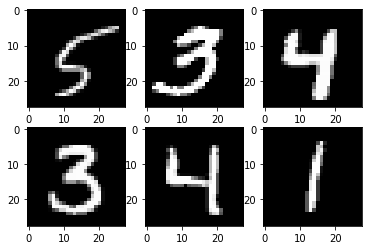

In [28]:
# Plot this
for i in range(6):  # 6 samples
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')  # [0] for the first color channel
plt.show()

In [29]:
# Let's create a neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):  # Num classes = output size
        super(NeuralNet, self).__init__()
        # Layers
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()  # Activation function
        self.layer2 = nn.Linear(hidden_size, num_classes)  # Output layer
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        # No softmax as we're applying cross entropy loss
        return out

In [30]:
# Create the model
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and Optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [35]:
# Training loop
n_total_steps = len(train_loader)

print("Reshaping...")
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Reshape the images from 100, 1, 28, 28 to 100, 784
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss_value = loss(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        # Print info
        if (i + 1) % 100 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Step {i + 1}/{n_total_steps}, Loss: {loss_value.item():.4f}')


# Testing and Evaluation of the model
# Don't compute gradients for these steps
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        # Reshape
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predictions = torch.max(outputs, 1)  # Along first dimension
        n_samples += labels.shape[0]  # Will give number of samples in current batch
        # n_samples += labels.size(0) is also valid
        n_correct += (predictions == labels).sum().item()
    
    acc = 100.0 * n_correct / n_samples

    print(f'Accuracy: {acc:.4f}%')

Reshaping...
Epoch 1/2, Step 100/600, Loss: 0.0853
Epoch 1/2, Step 200/600, Loss: 0.0394
Epoch 1/2, Step 300/600, Loss: 0.0513
Epoch 1/2, Step 400/600, Loss: 0.1161
Epoch 1/2, Step 500/600, Loss: 0.0467
Epoch 1/2, Step 600/600, Loss: 0.0803
Epoch 2/2, Step 100/600, Loss: 0.0271
Epoch 2/2, Step 200/600, Loss: 0.0799
Epoch 2/2, Step 300/600, Loss: 0.0390
Epoch 2/2, Step 400/600, Loss: 0.0154
Epoch 2/2, Step 500/600, Loss: 0.0319
Epoch 2/2, Step 600/600, Loss: 0.0471
Accuracy: 97.5100%
